In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import logging
from PIL import Image

In [2]:
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

In [3]:
import importlib
import euler_utils
importlib.reload(euler_utils)

<module 'euler_utils' from '/cluster/home/mfrancesc/IVT/eqasim-java/switzerland/WaitTimeValidation/euler_utils.py'>

In [4]:
last_iter = 100

In [5]:
main_folder = '/cluster/work/ivt_vpl/mfrancesc/SA_scenario/'

In [6]:
no_rej_4000 = euler_utils.read_output(main_folder + 'no_rejections_4000', last_iter)
euler_utils.compute_delay_factor_from_estimated(no_rej_4000['drt_trips_stats'])

  0%|          | 0/101 [00:00<?, ?it/s]2023-02-07 08:49:00 INFO     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2023-02-07 08:49:00 INFO     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
100%|██████████| 101/101 [00:00<00:00, 419.98it/s]


In [ ]:
no_rej_6000 = euler_utils.read_output(main_folder + 'no_rejections_6000', last_iter)
euler_utils.compute_delay_factor_from_estimated(no_rej_6000['drt_trips_stats'])

In [ ]:
rej_4000 = euler_utils.read_output(main_folder + 'rejections_4000', last_iter)
euler_utils.compute_delay_factor_from_estimated(rej_4000['drt_trips_stats'])

In [ ]:
rej_6000 = euler_utils.read_output(main_folder + 'rejections_6000', last_iter)
euler_utils.compute_delay_factor_from_estimated(rej_6000['drt_trips_stats'])

# Occupancy profiles

In [7]:
occupancy_profile_path = '/ITERS/it.' + str(last_iter) + '/' + str(last_iter) + '.occupancy_time_profiles_Line_drt.png'
folders = ['no_rejections_4000', 'no_rejections_6000', 'rejections_4000', 'rejections_6000']
occupancy_profile_paths = [main_folder + f + occupancy_profile_path for f in folders]


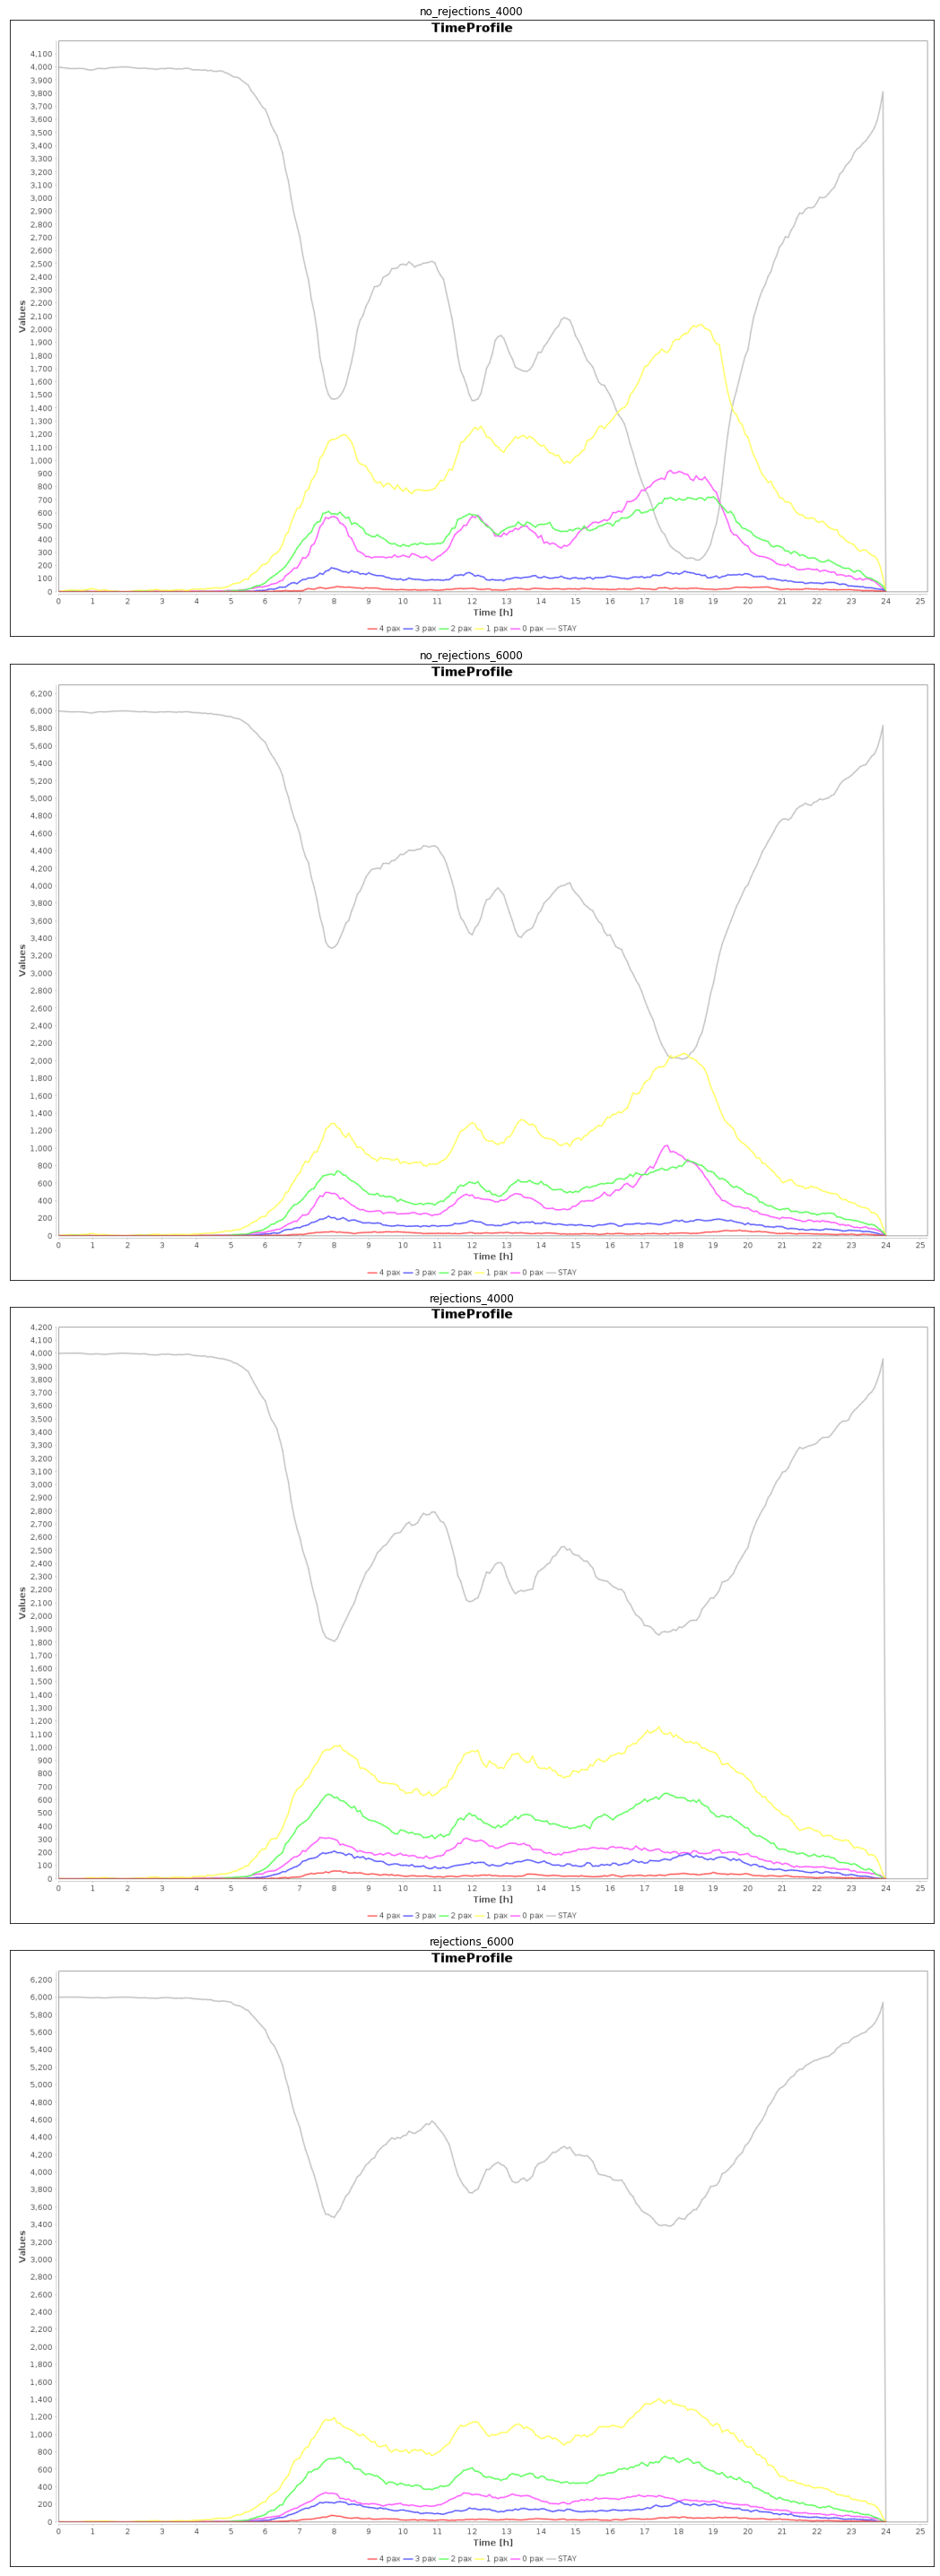

In [8]:
plt.figure(figsize=(25,40))
for i in range(1,5):
    plt.subplot(4,1,i)
    plt.imshow(Image.open(occupancy_profile_paths[i-1]))
    plt.xticks([])
    plt.yticks([])
    plt.title(occupancy_profile_paths[i-1].split('/')[6])
plt.tight_layout()
plt.show()

# Euclidean distance distribution

In [9]:
def plot_euclidean_distance_ditribution(it_drt_trips_stats):
    euclidean_distance = np.sqrt((no_rej_4000['drt_trips_stats'][100].startX -no_rej_4000['drt_trips_stats'][100].endX)**2 + (no_rej_4000['drt_trips_stats'][100].startY -no_rej_4000['drt_trips_stats'][100].endY)**2)
    display(euclidean_distance.describe(percentiles=[.25,.50,.75,.90,.95,.99]).to_frame().transpose())
    plt.hist(euclidean_distance / 1000, range=(0,10))
    plt.xlabel('Euclidean distance (km)')
    plt.ylabel('Number of DRT trips')
    plt.show()

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
0,218240.0,1734.47037,2091.906524,5.460794,385.25193,871.133458,2275.178735,4618.702938,6192.665635,9576.492854,19963.194883


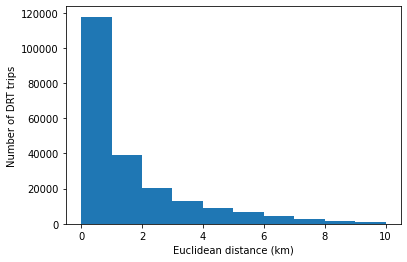

In [10]:
plot_euclidean_distance_ditribution(no_rej_4000['drt_trips_stats'][100])

We see that 75% of the drt trips are of less than 2.3 km

# Delay factor and wait time

In [11]:
def avg_by_time_bin(drt_trips_stats, column, start_time=6, end_time=24, bin_duration_min=30):
    legs = drt_trips_stats.copy()
    n_bins = (end_time - start_time) * 60 // bin_duration_min
    bins = [start_time*3600 + i*bin_duration_min*60 for i in range(0,n_bins+1)]
    legs['time_bin'] = pd.cut(legs.startTime, bins).map(lambda x: int((x.left + x.right)/2))
    if column == 'compute_total_delay_factor_estimated':
        grouped = legs.groupby(['time_bin'])['totalTravelTime'].sum() / legs.groupby(['time_bin'])['estimatedUnsharedTime'].sum()
    elif column == 'compute_total_delay_factor_router':
        grouped = legs.groupby(['time_bin'])['totalTravelTime'].sum() / legs.groupby(['time_bin'])['routerUnsharedTime'].sum()
    else:
        grouped = legs.groupby(['time_bin'])[column].mean()
    return grouped

In [12]:
def avg_by_euclidean_distance_bin(drt_trips_stats, column, min_distance=0, max_distance=5000, bin_distance_m=200):
    legs = drt_trips_stats.copy()
    n_bins = (max_distance - min_distance) // bin_distance_m
    distance_bins = [i*bin_distance_m for i in range(n_bins + 1)]
    legs['euclidean_distance'] = np.sqrt((legs.startX - legs.endX)**2 + (legs.startY - legs.endY)**2)
    legs['distance_bin'] = pd.cut(legs.euclidean_distance, distance_bins).map(lambda x: int((x.left + x.right)/2))
    if column == 'compute_total_delay_factor_estimated':
        grouped = legs.groupby(['distance_bin'])['totalTravelTime'].sum() / legs.groupby(['distance_bin'])['estimatedUnsharedTime'].sum()
    elif column == 'compute_total_delay_factor_router':
        grouped = legs.groupby(['distance_bin'])['totalTravelTime'].sum() / legs.groupby(['distance_bin'])['routerUnsharedTime'].sum()
    else:
        grouped = legs.groupby(['distance_bin'])[column].mean()
    return grouped

In [13]:
def plot_delay_factor(it_drt_trip_stats, start_time, end_time, bin_duration_min, min_distance, max_distance, bin_distance_m):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    delayFactor_avg = avg_by_time_bin(filtered_without_router_zeros, 'delayFactor', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorEstimatedDRT_avg = avg_by_time_bin(filtered_without_router_zeros, 'delayFactorEstimatedDRT', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorComputedRouter_avg = avg_by_time_bin(filtered_without_router_zeros, 'compute_total_delay_factor_router', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorComputedEstimatedDRT_avg = avg_by_time_bin(filtered_without_router_zeros, 'compute_total_delay_factor_estimated', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    plt.figure(figsize=(15,15))
    
    plt.subplot(2,2,1)
    xticks = [z*3600 for z in range(start_time, end_time+1, 2)]
    xticks_labels = [str(z) + 'h' for z in range(start_time, end_time+1, 2)]
    
    plt.plot(delayFactor_avg.index.values, delayFactor_avg.values, 'ro-', label='Avg of delay factor using router')
    plt.plot(delayFactorEstimatedDRT_avg.index.values, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
    plt.plot(delayFactorComputedRouter_avg.index.values, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
    plt.plot(delayFactorComputedEstimatedDRT_avg.index.values, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
    plt.legend()
    plt.xlim(start_time*3600,end_time*3600)
    plt.xticks(xticks, xticks_labels)
    plt.title('Delay Factor by departure time\n (filtering the trips with 0 predicted time by the router)')
    plt.ylabel('Delay Factor')
    plt.xlabel('Time of the day')

    
    plt.subplot(2,2,3)
    
    delayFactorEstimatedDRT_avg = avg_by_time_bin(it_drt_trip_stats, 'delayFactorEstimatedDRT', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorComputedRouter_avg = avg_by_time_bin(it_drt_trip_stats, 'compute_total_delay_factor_router', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorComputedEstimatedDRT_avg = avg_by_time_bin(it_drt_trip_stats, 'compute_total_delay_factor_estimated', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    plt.plot(delayFactorEstimatedDRT_avg.index.values, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
    plt.plot(delayFactorComputedRouter_avg.index.values, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
    plt.plot(delayFactorComputedEstimatedDRT_avg.index.values, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
    plt.legend()
    plt.xlim(start_time*3600,end_time*3600)
    plt.xticks(xticks, xticks_labels)
    plt.title('Delay Factor by departure time\n (without filtering)')
    plt.ylabel('Delay Factor')
    plt.xlabel('Time of the day')

    
    
    plt.subplot(2,2,2)
    
    delayFactor_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'delayFactor', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorEstimatedDRT_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'delayFactorEstimatedDRT', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorComputedRouter_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'compute_total_delay_factor_router', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorComputedEstimatedDRT_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'compute_total_delay_factor_estimated',min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    plt.plot(np.array(delayFactor_avg.index.values)/1000, delayFactor_avg.values, 'ro-', label='Avg of delay factor using router')
    plt.plot(np.array(delayFactorEstimatedDRT_avg.index.values)/1000, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
    plt.plot(np.array(delayFactorComputedRouter_avg.index.values)/1000, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
    plt.plot(np.array(delayFactorComputedEstimatedDRT_avg.index.values)/1000, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
    plt.legend()
    plt.title('Delay Factor by euclidean distance\n (filtering the trips with 0 predicted time by the router)')
    plt.xlabel('Euclidean distance (km)')
    plt.ylabel('Delay Factor')
    
    plt.subplot(2,2,4)
    
    delayFactor_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'delayFactor', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorEstimatedDRT_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'delayFactorEstimatedDRT', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorComputedRouter_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'compute_total_delay_factor_router', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorComputedEstimatedDRT_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'compute_total_delay_factor_estimated',min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    
    # TODO: Ask if we should plot this one (here we can see that only trips with low distance have 0 prediction)
    plt.plot(np.array(delayFactorEstimatedDRT_avg.index.values)/1000, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
    plt.plot(np.array(delayFactorComputedRouter_avg.index.values)/1000, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
    plt.plot(np.array(delayFactorComputedEstimatedDRT_avg.index.values)/1000, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
    plt.legend()
    plt.title('Delay Factor by euclidean distance\n (without filtering)')
    plt.xlabel('Euclidean distance (km)')
    plt.ylabel('Delay Factor')
    plt.tight_layout()
    plt.show()
    
    

In [14]:
start_time = 6
end_time = 24
bin_duration_min = 15
min_distance = 0
max_distance = 10000
bin_distance_m = 200

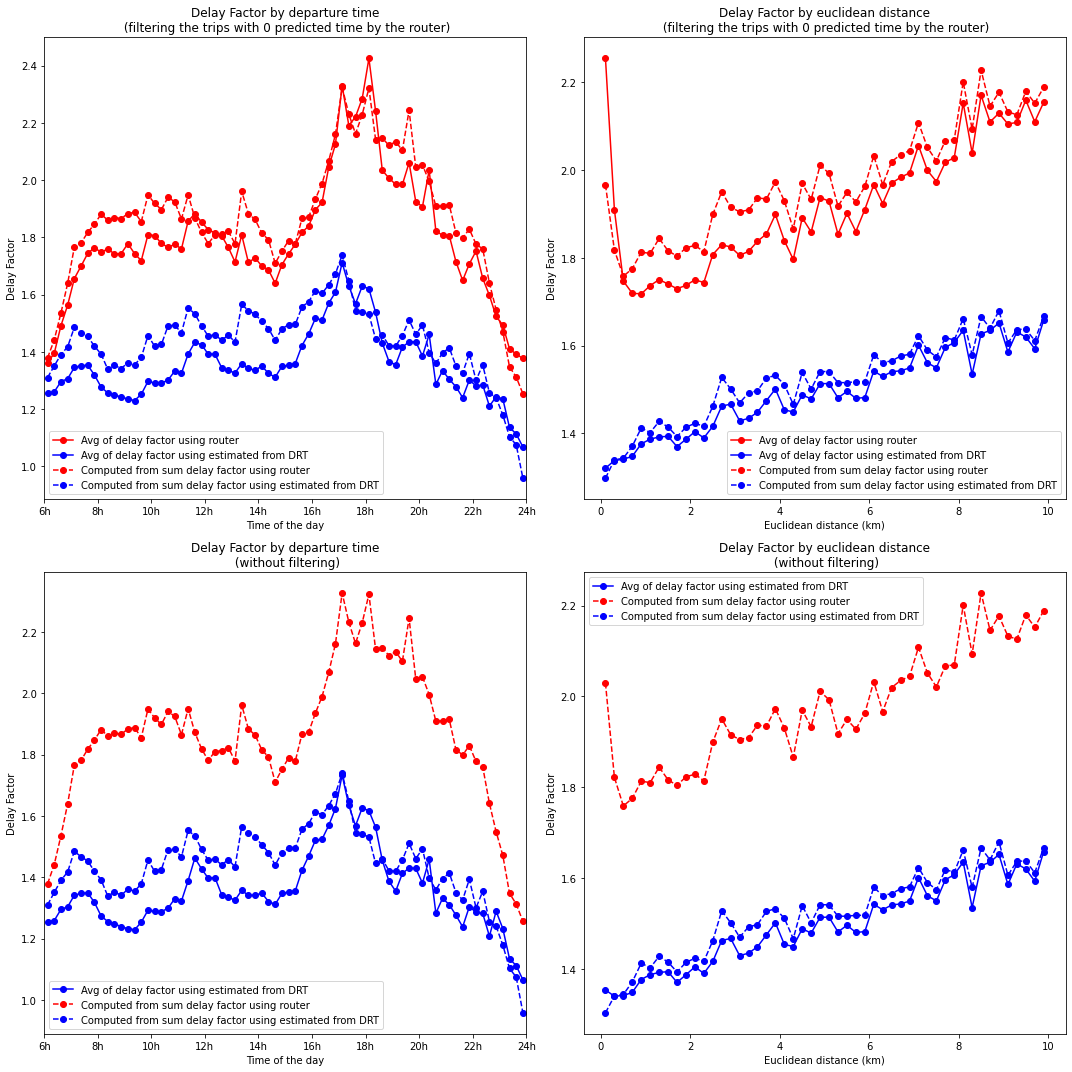

In [15]:
plot_delay_factor(no_rej_4000['drt_trips_stats'][100], start_time, end_time, bin_duration_min,
                 min_distance, max_distance, bin_distance_m)

## We redo the top line plots with multiple time and distance bins size

In [16]:
def plot_df_multiple_time_bins(it_drt_trip_stats, start_time, end_time, bin_durations_min):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    n_rows = (len(bin_durations_min) - 1) // 2 + 1
    plt.figure(figsize=(15, n_rows * 7.5))
    
    xticks = [z*3600 for z in range(start_time, end_time+1, 2)]
    xticks_labels = [str(z) + 'h' for z in range(start_time, end_time+1, 2)]
    
    for idx,time_bin in enumerate(bin_durations_min, start=1):
        delayFactor_avg = avg_by_time_bin(filtered_without_router_zeros, 'delayFactor', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=time_bin)
        delayFactorEstimatedDRT_avg = avg_by_time_bin(filtered_without_router_zeros, 'delayFactorEstimatedDRT', start_time=start_time, 
                                         end_time=end_time, bin_duration_min=time_bin)
        delayFactorComputedRouter_avg = avg_by_time_bin(filtered_without_router_zeros, 'compute_total_delay_factor_router', start_time=start_time, 
                                         end_time=end_time, bin_duration_min=time_bin)
        delayFactorComputedEstimatedDRT_avg = avg_by_time_bin(filtered_without_router_zeros, 'compute_total_delay_factor_estimated', start_time=start_time, 
                                         end_time=end_time, bin_duration_min=time_bin)
    
        plt.subplot(n_rows,2,idx)
        plt.plot(delayFactor_avg.index.values, delayFactor_avg.values, 'ro-', label='Avg of delay factor using router')
        plt.plot(delayFactorEstimatedDRT_avg.index.values, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
        plt.plot(delayFactorComputedRouter_avg.index.values, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
        plt.plot(delayFactorComputedEstimatedDRT_avg.index.values, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')

        #plt.plot(delayFactor_avg.index.values, delayFactor_avg.values, 'o-', label=str(time_bin) + 'min')
        plt.legend()
        plt.xlim(start_time*3600,end_time*3600)
        plt.xticks(xticks, xticks_labels)
        plt.title('Delay Factor by departure time\n (filtering the trips with 0 predicted time by the router)\nTime bin = ' + str(time_bin) + ' min')
        plt.ylabel('Delay Factor')
        plt.xlabel('Time of the day')
    
    plt.tight_layout()
    plt.show()
        
    

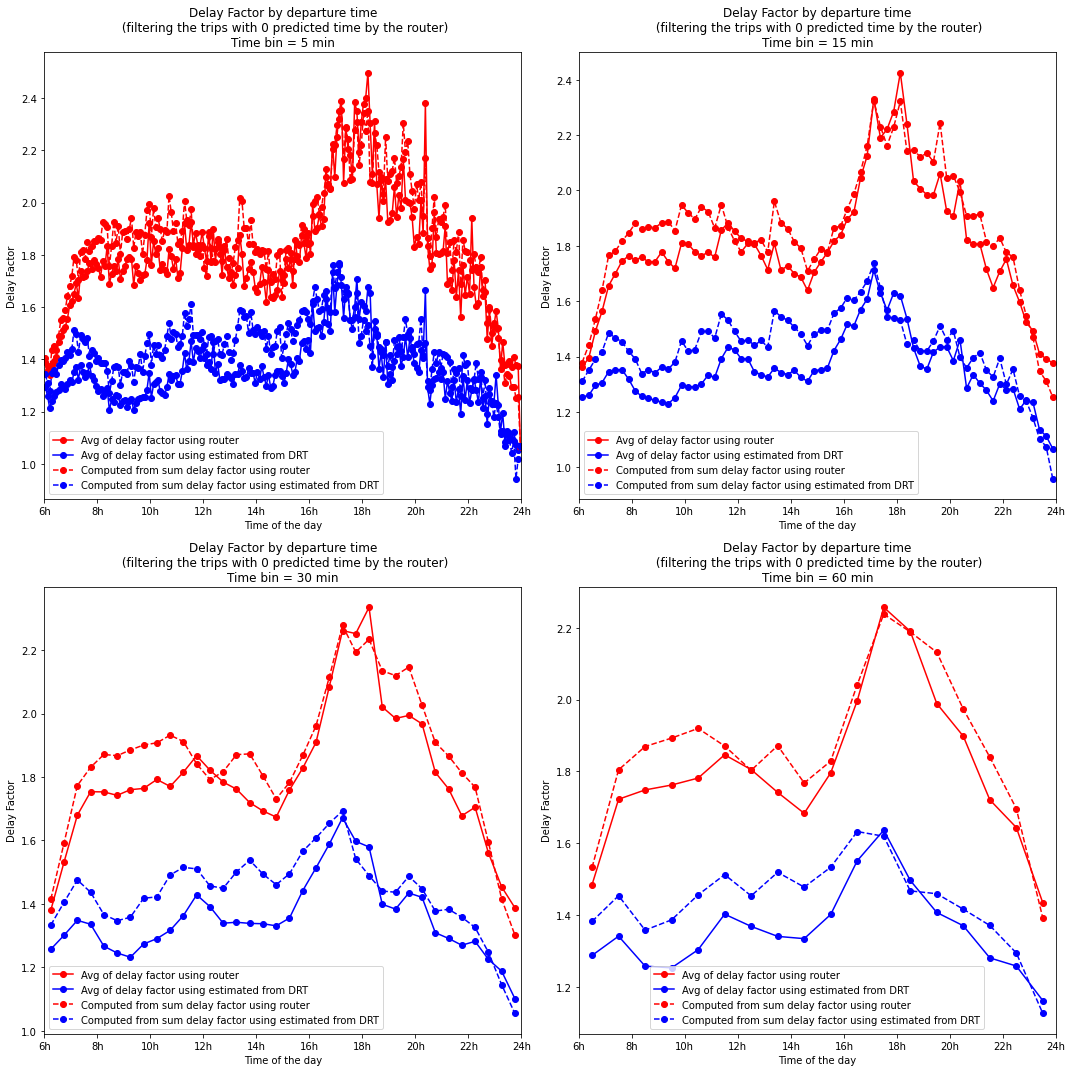

In [17]:
plot_df_multiple_time_bins(no_rej_4000['drt_trips_stats'][100], start_time, end_time, [5,15,30,60])

In [18]:
def plot_df_multiple_distance_bins(it_drt_trip_stats,  min_distance, max_distance, bin_distances_m):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    n_rows = (len(bin_distances_m) - 1) // 2 + 1
    plt.figure(figsize=(15, n_rows * 7.5))
    
    for idx,distance_bin in enumerate(bin_distances_m, start=1):
        delayFactor_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'delayFactor', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=distance_bin)
        delayFactorEstimatedDRT_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'delayFactorEstimatedDRT', min_distance=min_distance, 
                                         max_distance=max_distance, bin_distance_m=distance_bin)
        delayFactorComputedRouter_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'compute_total_delay_factor_router', min_distance=min_distance, 
                                         max_distance=max_distance, bin_distance_m=distance_bin)
        delayFactorComputedEstimatedDRT_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'compute_total_delay_factor_estimated',min_distance=min_distance, 
                                         max_distance=max_distance, bin_distance_m=distance_bin)
        plt.subplot(n_rows,2,idx)
        
        plt.plot(np.array(delayFactor_avg.index.values)/1000, delayFactor_avg.values, 'ro-', label='Avg of delay factor using router')
        plt.plot(np.array(delayFactorEstimatedDRT_avg.index.values)/1000, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
        plt.plot(np.array(delayFactorComputedRouter_avg.index.values)/1000, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
        plt.plot(np.array(delayFactorComputedEstimatedDRT_avg.index.values)/1000, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
        plt.legend()
        plt.title('Delay Factor by euclidean distance\n (filtering the trips with 0 predicted time by the router)\nDistance bin = ' + str(distance_bin) + 'm')
        plt.xlabel('Euclidean distance (km)')
        plt.ylabel('Delay Factor')
    
    plt.tight_layout()
    plt.show()

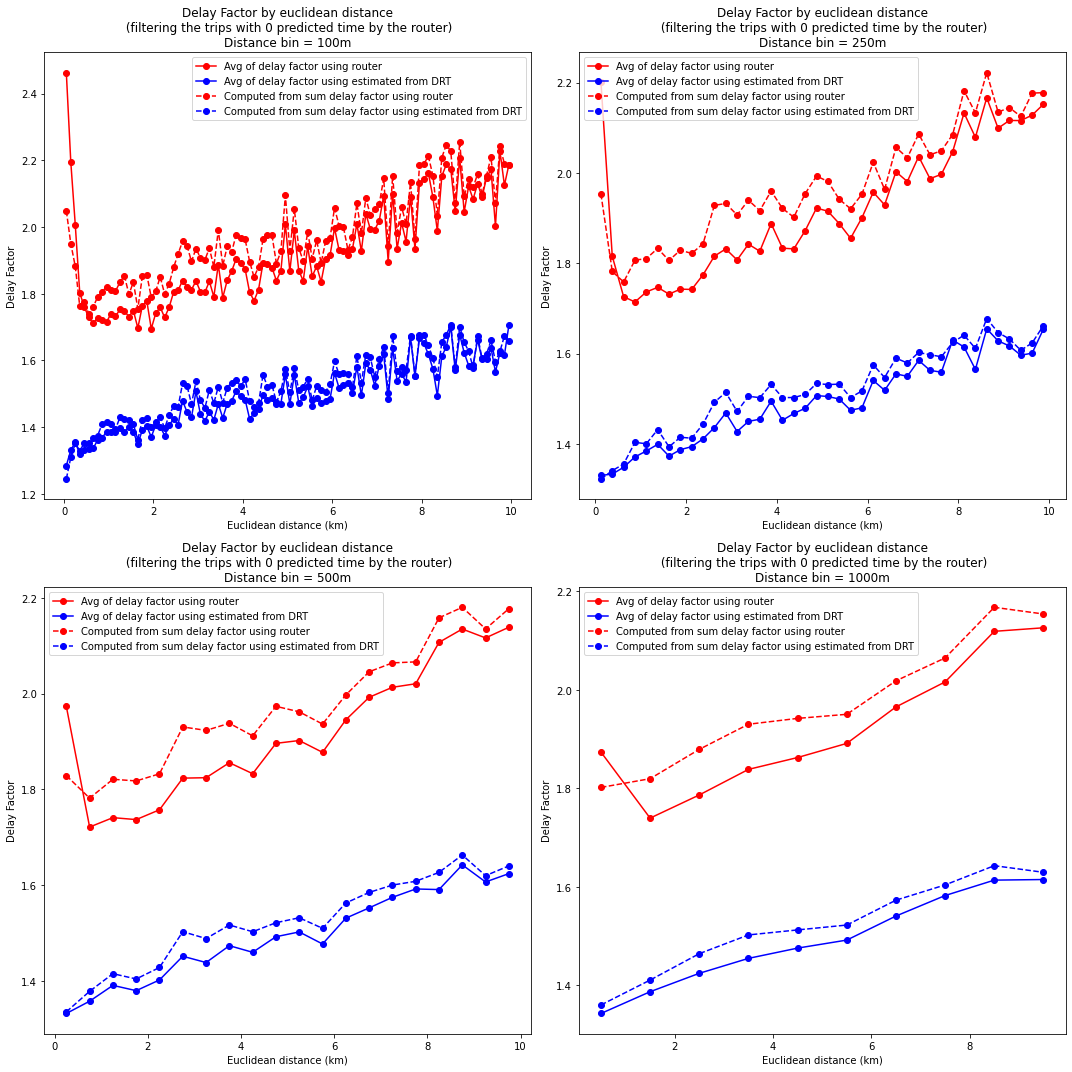

In [19]:
plot_df_multiple_distance_bins(no_rej_4000['drt_trips_stats'][100], min_distance, max_distance, [100,250,500,1000])

The estimated travel time by the DRT is usually closer to the travel time -> DF for the estimated from DRT is smaller

In [20]:
def plot_waiting_time(it_drt_trip_stats, start_time, end_time, bin_duration_min, min_distance, max_distance, bin_distance_m):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    
    waitTime_avg = avg_by_time_bin(filtered_without_router_zeros, 'waitTime', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    
    plt.figure(figsize=(15,15))
    
    plt.subplot(2,2,1)
    xticks = [z*3600 for z in range(start_time, end_time+1, 2)]
    xticks_labels = [str(z) + 'h' for z in range(start_time, end_time+1, 2)]
    
    plt.plot(waitTime_avg.index.values, waitTime_avg.values/60, 'o-', label='Avg of wait time')
    plt.xlim(start_time*3600,end_time*3600)
    plt.xticks(xticks, xticks_labels)
    plt.title('Wait time by departure time\n (filtering the trips with 0 predicted time by the router)')
    plt.ylabel('Wait time (min)')
    plt.xlabel('Time of the day')
    
    plt.subplot(2,2,3)
    waitTime_avg = avg_by_time_bin(it_drt_trip_stats, 'waitTime', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    plt.plot(waitTime_avg.index.values, waitTime_avg.values/60, 'o-', label='Avg of wait time')
    plt.xlim(start_time*3600,end_time*3600)
    plt.xticks(xticks, xticks_labels)
    plt.title('Wait time by departure time\n (without filtering)')
    plt.ylabel('Wait time (min)')
    plt.xlabel('Euclidean distance (km)')
    
    plt.subplot(2,2,2)
    waitTime_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'waitTime', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    plt.plot(np.array(waitTime_avg.index.values) / 1000, waitTime_avg.values/60, 'o-', label='Avg of wait time')
    plt.title('Wait time by euclidean distance\n (filtering the trips with 0 predicted time by the router)')
    plt.xlabel('Euclidean distance (km)')
    plt.xlabel('Time of the day')
    plt.subplot(2,2,4)
    waitTime_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'waitTime', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    plt.plot(np.array(waitTime_avg.index.values) / 1000, waitTime_avg.values/60, 'o-', label='Avg of wait time')
    plt.title('Wait time by euclidean distance\n (without filtering)')
    plt.ylabel('Wait time (min)')
    plt.xlabel('Euclidean distance (km)')
    
    
    plt.show()
    

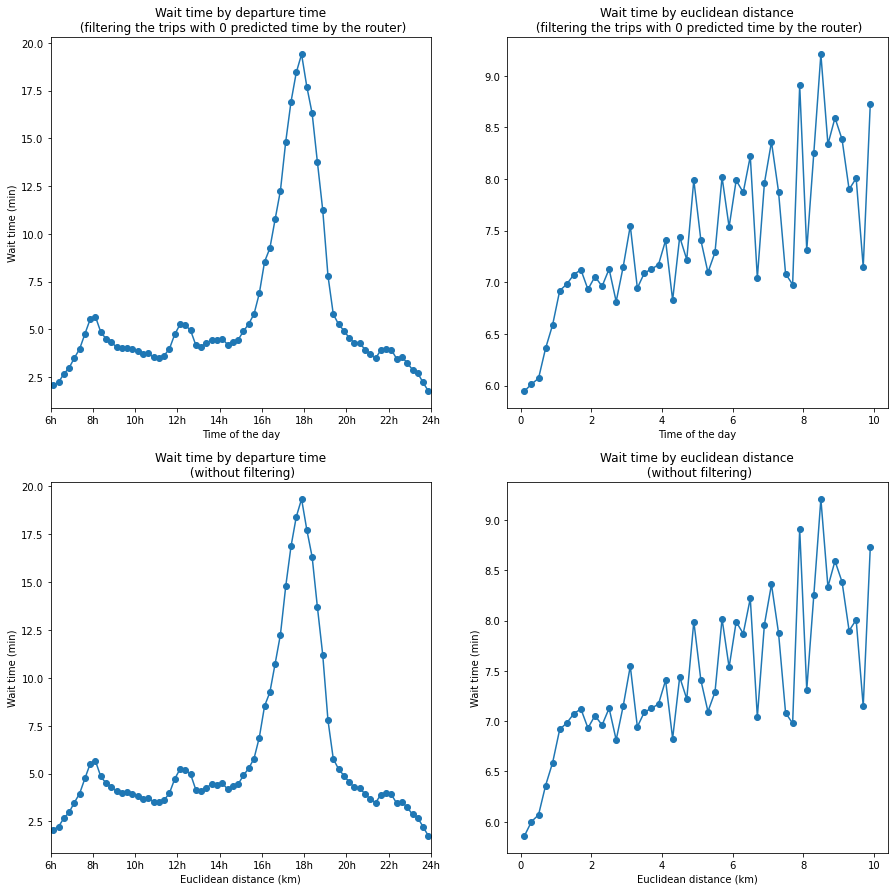

In [21]:
plot_waiting_time(no_rej_4000['drt_trips_stats'][100], start_time, end_time, bin_duration_min,
                 min_distance, max_distance, bin_distance_m)

## We redo the top line plots with different time and distance bins

In [22]:
def plot_waiting_time_multiple_time_bins(it_drt_trip_stats, start_time, end_time, bin_durations_min):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    n_rows = (len(bin_durations_min) - 1) // 2 + 1
    plt.figure(figsize=(15, n_rows * 7.5))
    
    xticks = [z*3600 for z in range(start_time, end_time+1, 2)]
    xticks_labels = [str(z) + 'h' for z in range(start_time, end_time+1, 2)]
    
    for idx,time_bin in enumerate(bin_durations_min, start=1):
        waitTime_avg = avg_by_time_bin(filtered_without_router_zeros, 'waitTime', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=time_bin)
        
        plt.subplot(n_rows,2,idx)
        plt.plot(waitTime_avg.index.values, waitTime_avg.values/60, 'o-', label='Avg of wait time')        
        plt.xlim(start_time*3600,end_time*3600)
        plt.xticks(xticks, xticks_labels)
        plt.title('Wait time by departure time\n (filtering the trips with 0 predicted time by the router)\nTime bin = ' + str(time_bin) + ' min')
        plt.ylabel('Wait time (min)')
        plt.xlabel('Time of the day')
    
    plt.tight_layout()
    plt.show()
        
    

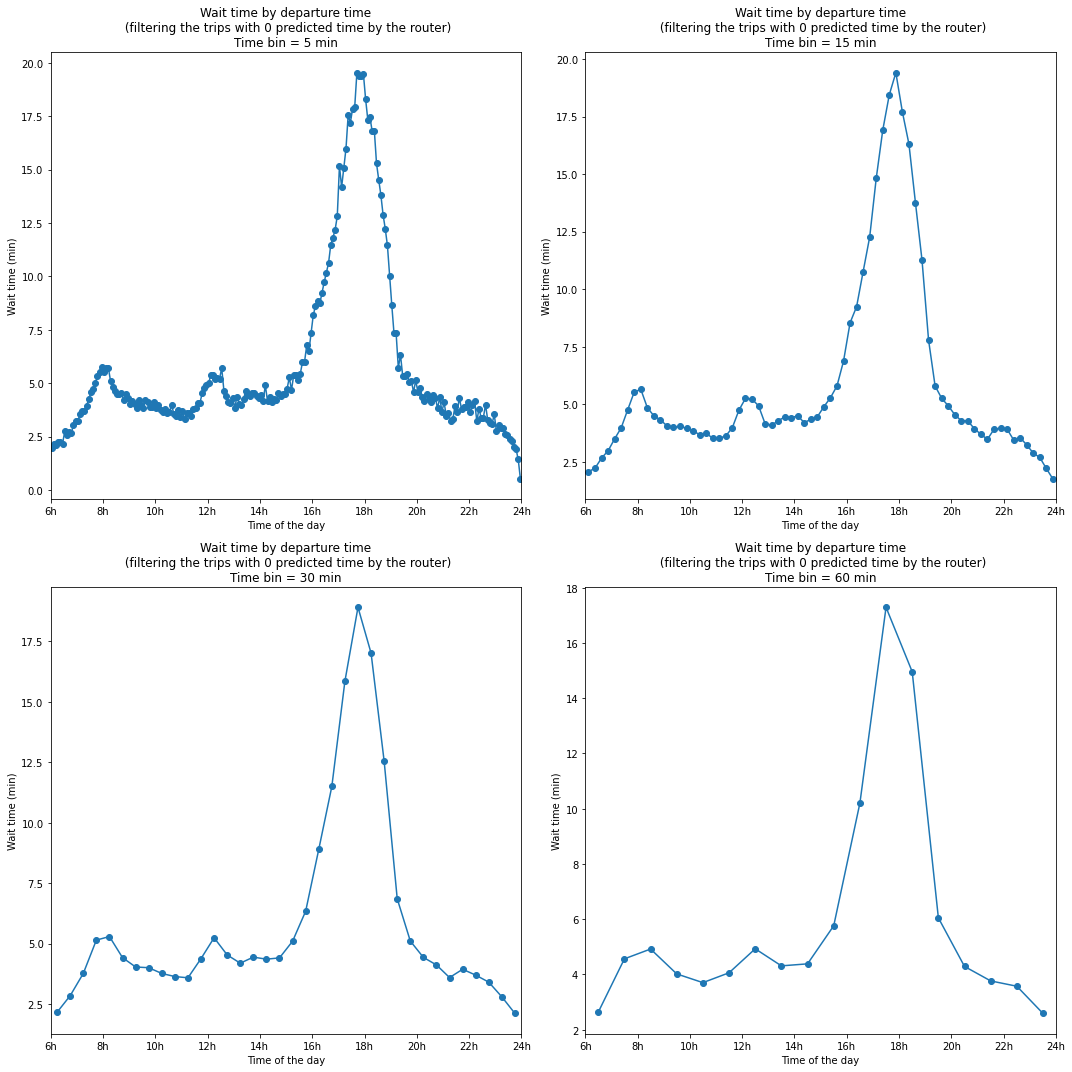

In [23]:
plot_waiting_time_multiple_time_bins(no_rej_4000['drt_trips_stats'][100], start_time, end_time, [5,15,30,60])

In [24]:
def plot_waiting_time_multiple_distance_bins(it_drt_trip_stats,  min_distance, max_distance, bin_distances_m):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    n_rows = (len(bin_distances_m) - 1) // 2 + 1
    plt.figure(figsize=(15, n_rows * 7.5))
    
    for idx,distance_bin in enumerate(bin_distances_m, start=1):
        plt.subplot(n_rows,2,idx)
        waitTime_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'waitTime', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=distance_bin)
        plt.plot(np.array(waitTime_avg.index.values) / 1000, waitTime_avg.values/60, 'o-', label='Avg of wait time')
        plt.title('Wait time by euclidean distance\n (filtering the trips with 0 predicted time by the router)\nDistance bin = ' + str(distance_bin) + 'm')
        plt.xlabel('Euclidean distance (km)')
        plt.xlabel('Time of the day')
    
    plt.tight_layout()
    plt.show()

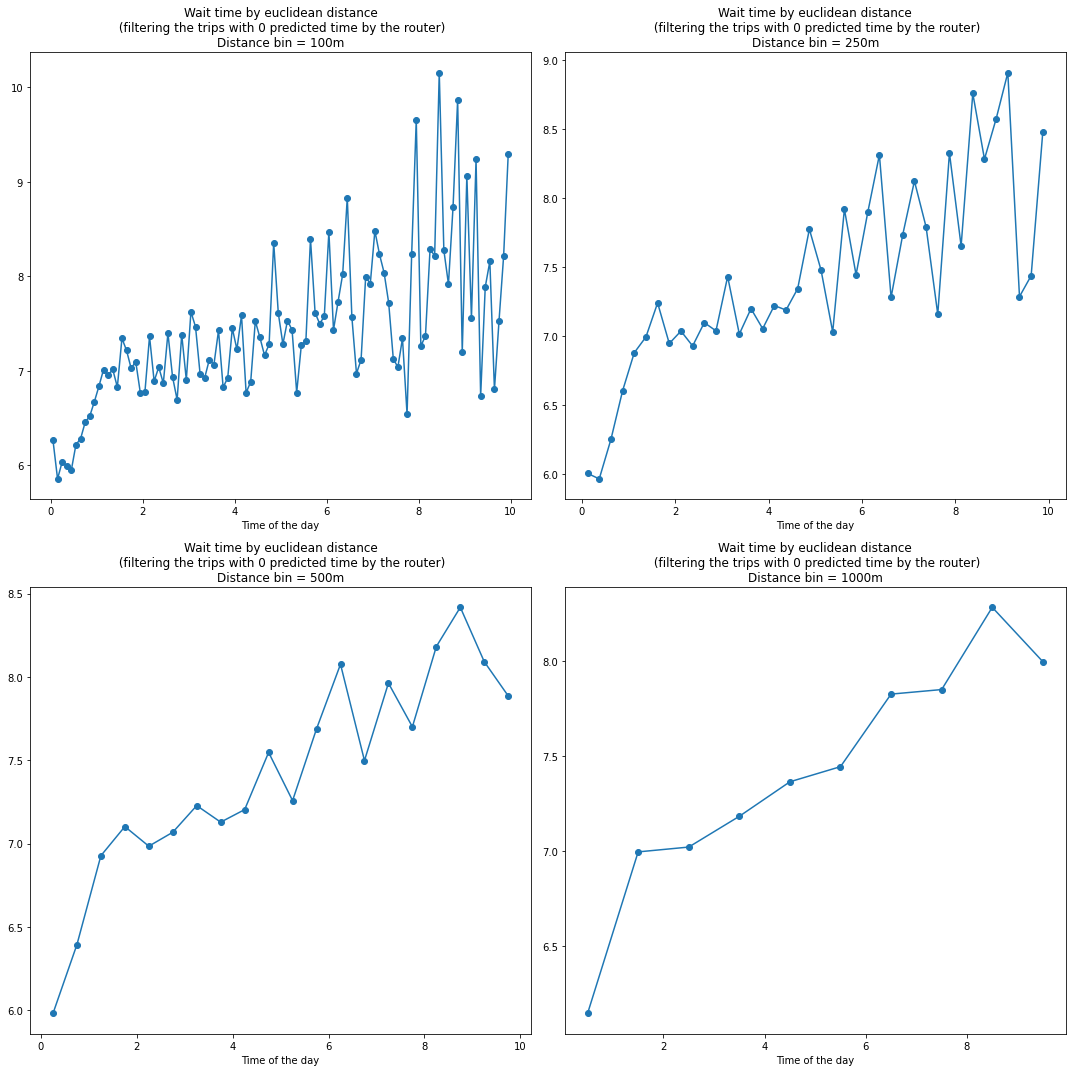

In [25]:
plot_waiting_time_multiple_distance_bins(no_rej_4000['drt_trips_stats'][100], min_distance, max_distance, [100,250,500,1000])

# Difference between router and estimated

In [26]:
def plot_difference_estimated_router(it_drt_trip_stats):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    abs_difference = np.abs(filtered_without_router_zeros['estimatedUnsharedTime'] - filtered_without_router_zeros['routerUnsharedTime'])
    abs_difference_min = abs_difference / 60 #absolute difference in minutes
    rel_difference = abs_difference / filtered_without_router_zeros['estimatedUnsharedTime']
    print('Description of abs difference in minutes')
    display(abs_difference_min.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99,0.999]).to_frame().transpose())
    print('Description of relative difference')
    display(rel_difference.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99,0.999]).to_frame().transpose())
    plt.figure(figsize=(15,20))
    plt.subplot(2,2,1)
    plt.hist(abs_difference_min, bins=100, range=(0,15), density=True)
    plt.title('Absolute difference')
    plt.xlabel('difference (min)')
    plt.subplot(2,2,2)
    plt.hist(rel_difference, bins=100, range=(0,1), density=True)
    plt.title('Relative difference')
    plt.subplot(2,2,3)
    plt.boxplot(abs_difference_min, positions=[1])
    plt.ylim(-1,15)
    ax2 = plt.gca().twinx()
    ax2.boxplot(abs_difference_min, positions=[2])
    plt.xticks([1,2],['Zoomed','Non zoomed'])
    plt.subplot(2,2,4)
    plt.boxplot(rel_difference, positions=[1])
    plt.ylim(-0.1,1)
    ax2 = plt.gca().twinx()
    ax2.boxplot(rel_difference, positions=[2])
    plt.xticks([1,2],['Zoomed','Non zoomed'])
    plt.tight_layout()
    plt.show()

In [27]:
no_rej_4000['drt_trips_stats'][100].iloc[np.abs(no_rej_4000['drt_trips_stats'][100]['estimatedUnsharedTime'] - no_rej_4000['drt_trips_stats'][100]['routerUnsharedTime']).argmax()]

personId                   2.017400e+14
startTime                  6.065400e+04
totalTravelTime            1.305400e+04
routerUnsharedTime         1.297058e+04
estimatedUnsharedTime      1.020327e+03
delayFactor                1.006432e+00
waitTime                   1.990000e+02
startX                     2.693723e+06
startY                     1.248622e+06
endX                       2.690963e+06
endY                       1.251315e+06
delayFactorEstimatedDRT    1.279393e+01
Name: 10343, dtype: float64

Description of abs difference in minutes


,count,mean,std,min,25%,50%,75%,90%,95%,99%,99.9%,max
0,215986.0,1.955866,4.494985,0.000027,0.271958,0.511535,1.307748,4.98808,9.660681,22.040813,42.677229,199.170861


Description of relative difference


,count,mean,std,min,25%,50%,75%,90%,95%,99%,99.9%,max
0,215986.0,0.216554,0.31205,0.000002,0.079062,0.157495,0.29277,0.467742,0.587206,0.807082,2.195529,74.569784


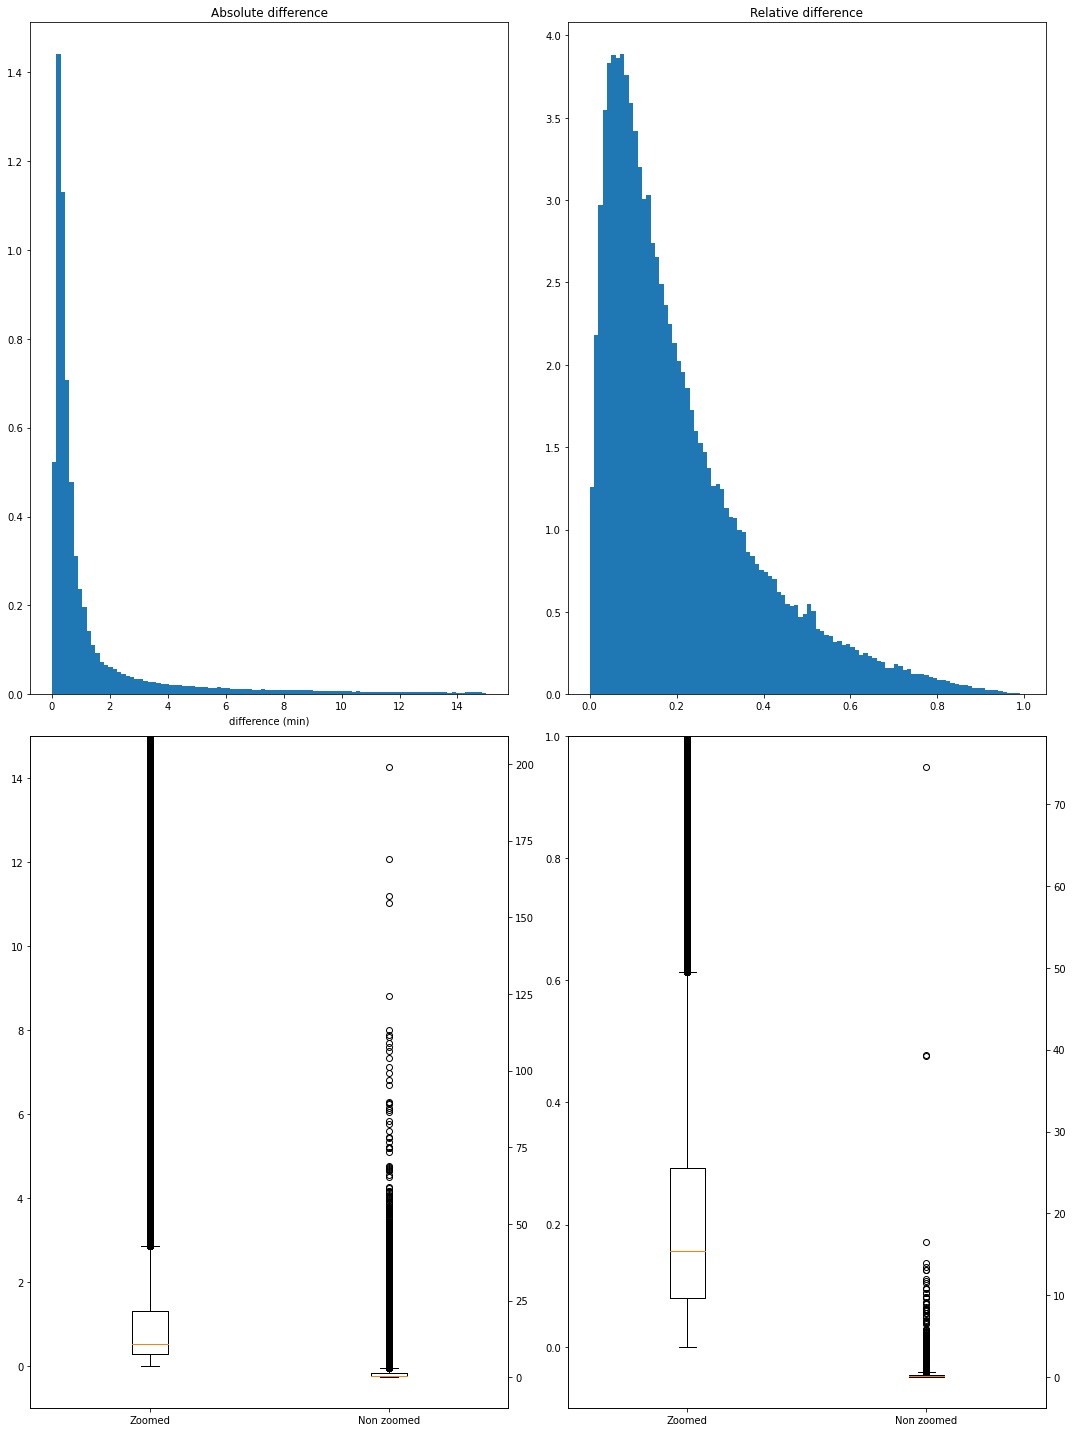

In [28]:
plot_difference_estimated_router(no_rej_4000['drt_trips_stats'][100])

In [29]:
def show_top_differences(it_drt_trip_stats, n=20):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0].copy(deep=True)
    filtered_without_router_zeros['abs_difference'] = np.abs(filtered_without_router_zeros['estimatedUnsharedTime'] - filtered_without_router_zeros['routerUnsharedTime'])
    filtered_without_router_zeros['abs_difference_min'] = filtered_without_router_zeros['abs_difference'] / 60 #absolute difference in minutes
    filtered_without_router_zeros['rel_difference'] = filtered_without_router_zeros['abs_difference'] / filtered_without_router_zeros['estimatedUnsharedTime']
    
    cols = ['startTime', 'totalTravelTime', 'routerUnsharedTime', 'estimatedUnsharedTime', 'delayFactor', 'delayFactorEstimatedDRT', 'abs_difference', 'abs_difference_min', 'rel_difference']

    top_abs_diff = filtered_without_router_zeros['abs_difference'].sort_values(ascending=False)[0:n].index.values
    top_rel_diff = filtered_without_router_zeros['rel_difference'].sort_values(ascending=False)[0:n].index.values
    display(filtered_without_router_zeros.loc[top_abs_diff][cols])
    display(filtered_without_router_zeros.loc[top_rel_diff][cols])
#no_rej_4000['drt_trips_stats'][100].iloc[np.abs(no_rej_4000['drt_trips_stats'][100]['estimatedUnsharedTime'] - no_rej_4000['drt_trips_stats'][100]['routerUnsharedTime']).argmax()]

In [30]:
show_top_differences(no_rej_4000['drt_trips_stats'][100])

,startTime,totalTravelTime,routerUnsharedTime,estimatedUnsharedTime,delayFactor,delayFactorEstimatedDRT,abs_difference,abs_difference_min,rel_difference
10343,60654.0,13054.0,12970.579,1020.327362,1.006432,12.793933,11950.251638,199.170861,11.712174
4698,62734.0,12290.0,11989.186,1854.038892,1.025090,6.628771,10135.147108,168.919118,5.466523
63448,63207.0,11960.0,11445.880,2024.105540,1.044917,5.908783,9421.774460,157.029574,4.654784
92641,63264.0,11863.0,11586.322,2306.027802,1.023880,5.144344,9280.294198,154.671570,4.024364
105372,62458.0,10198.0,8919.349,1451.480349,1.143357,7.025930,7467.868651,124.464478,5.145002
135317,71133.0,14044.0,8240.263,1439.768299,1.704315,9.754347,6800.494701,113.341578,4.723326
140272,72477.0,8619.0,8255.556,1553.152644,1.044024,5.549358,6702.403356,111.706723,4.315354
115858,69798.0,15545.0,8352.179,1694.962322,1.861191,9.171295,6657.216678,110.953611,3.927649
109841,64097.0,9261.0,8399.406,1864.888867,1.102578,4.965980,6534.517133,108.908619,3.503971
127263,60676.0,8852.0,7745.358,1276.103172,1.142878,6.936743,6469.254828,107.820914,5.069539


,startTime,totalTravelTime,routerUnsharedTime,estimatedUnsharedTime,delayFactor,delayFactorEstimatedDRT,abs_difference,abs_difference_min,rel_difference
123127,65896.0,7672.0,6144.565,81.309813,1.248583,94.355155,6063.255187,101.054253,74.569784
11541,71630.0,2883.0,2396.883,59.363355,1.202812,48.565314,2337.519645,38.958661,39.376475
162711,70642.0,2883.0,2537.442,63.012755,1.136184,45.752642,2474.429245,41.240487,39.268704
107228,39099.0,6012.0,5714.264,326.945971,1.052104,18.388359,5387.318029,89.788634,16.477701
60486,69951.0,5418.0,5604.441,374.481587,0.966733,14.468001,5229.959413,87.165990,13.965865
62159,56221.0,6700.0,6402.067,444.168875,1.046537,15.084353,5957.898125,99.298302,13.413588
189193,78957.0,5837.0,6254.985,444.273319,0.933176,13.138309,5810.711681,96.845195,13.079137
159375,69881.0,3777.0,2035.967,144.875433,1.855138,26.070673,1891.091567,31.518193,13.053225
13183,50899.0,2616.0,2884.897,222.471500,0.906791,11.758810,2662.425500,44.373758,11.967490
10343,60654.0,13054.0,12970.579,1020.327362,1.006432,12.793933,11950.251638,199.170861,11.712174


We can see that the router usually gives prediciton that match more accurately the total travel time (although it's not a guarantee that it is correct) and there's also the problem that the router does predict 0 travel time for some short trips. So all in all we should take all this into account when choosing which data to use for the delayFactor, maybe use the router time by default and in case this one is 0 use the estimated by the DRT?

# Convergence of wait time and delay factor

In [31]:
def collect_timeData(averages):
    waitTimes = []
    delayFactors = []
    for df in averages:
        df = df.set_index('stat')
        waitTimes.append(df.loc['waitTime']['avg'])
        delayFactors.append(df.loc['delayFactor']['avg'])
    return np.array(waitTimes), np.array(delayFactors)

In [32]:
def compute_global_moving_average(drt_trips_stats, moving_window):
    waitTimes = []
    delayFactors = []
    for it, it_global_moving_avg in enumerate(drt_trips_stats):
        start = 0
        if it >= moving_window:
            start = it - moving_window + 1
        it_drt_trips_stats = pd.concat([drt_trips_stats[j] for j in range(start, it+1)])
        waitTimes.append(it_drt_trips_stats.waitTime.mean())
        # TODO: Change this one if we choose another method
        delayFactors.append(np.float64(it_drt_trips_stats.totalTravelTime.sum()) / it_drt_trips_stats.routerUnsharedTime.sum())
    return np.array(waitTimes), np.array(delayFactors)

In [33]:
def compute_global_successive_average(drt_trips_stats, weight):
    waitTimes = []
    delayFactors = []
    
    iters_wait_time_avg = []
    iters_delay_factor_avg = []
    for it_drt_trips_stats in drt_trips_stats:
        iters_wait_time_avg.append(it_drt_trips_stats.waitTime.mean())
        iters_delay_factor_avg.append(np.float64(it_drt_trips_stats.totalTravelTime.sum()) / it_drt_trips_stats.routerUnsharedTime.sum())
    iters_wait_time_successive_avg = []
    for it in range(len(iters_wait_time_avg)):
        if it == 0:
            iters_wait_time_successive_avg.append(iters_wait_time_avg[it])
            continue
        previous_avg = iters_wait_time_successive_avg[it-1]
        if np.isnan(previous_avg):
            iters_wait_time_successive_avg.append(iters_wait_time_avg[it])
            continue
        if np.isnan(iters_wait_time_avg[it]):
            iters_wait_time_successive_avg.append(previous_avg)
            continue
        iters_wait_time_successive_avg.append((1-weight) * previous_avg + weight * iters_wait_time_avg[it])       
    
    iters_delay_factor_successive_avg = []
    for it in range(len(iters_delay_factor_avg)):
        if it == 0:
            iters_delay_factor_successive_avg.append(iters_delay_factor_avg[it])
            continue
        previous_avg = iters_delay_factor_successive_avg[it-1]
        if np.isnan(previous_avg):
            iters_delay_factor_successive_avg.append(iters_delay_factor_avg[it])
            continue
        if np.isnan(iters_delay_factor_avg[it]):
            iters_delay_factor_successive_avg.append(previous_avg)
            continue
        iters_delay_factor_successive_avg.append((1-weight) * previous_avg + weight * iters_delay_factor_avg[it])
    
    return np.array(iters_wait_time_successive_avg), np.array(iters_delay_factor_successive_avg)

In [34]:
def plot_convergence_computed(output_dict, moving_windows, successive_weights):
    waitTimes_global, delayFactors_global = collect_timeData(output_dict['global_avg'])
    
    
    waitTimes_successive, delayFactors_successive = collect_timeData(output_dict['global_successive_avg'])
    waitTimes_moving, delayFactors_moving = collect_timeData(output_dict['global_moving_avg'])
    plt.figure(figsize=(15,15))
    plt.subplot(2,1,1)
    plt.plot(waitTimes_global / 60, label='global')
    plt.subplot(2,1,2)
    plt.plot(delayFactors_global, label='global')
    
    if moving_windows:
        for window in moving_windows:
            waitTimes_moving, delayFactors_moving = compute_global_moving_average(output_dict['drt_trips_stats'], window)
            plt.subplot(2,1,1)
            plt.plot(waitTimes_moving / 60, label='moving window = ' + str(window))
            plt.subplot(2,1,2)
            plt.plot(delayFactors_moving, label='moving window = ' + str(window))
    if successive_weights:
        for weight in successive_weights:
            waitTimes_successive, delayFactors_successive = compute_global_successive_average(output_dict['drt_trips_stats'], weight)
            plt.subplot(2,1,1)
            plt.plot(waitTimes_successive / 60, label='successive weight = ' + str(weight))
            plt.subplot(2,1,2)
            plt.plot(delayFactors_successive, label='successive weight = ' + str(weight))
    
    plt.subplot(2,1,1)
    plt.legend()
    plt.title('Convergence of average waitTime')
    plt.ylabel('waitTime (min)')
    plt.xlabel('Iteration')
    plt.subplot(2,1,2)
    plt.legend()
    plt.title('Convergence of average delayFactor')
    plt.ylabel('delayFactor')
    plt.xlabel('Iteration')
    plt.show()

<ipython-input-33-9e78bcf4d4a0>:9: RuntimeWarning: invalid value encountered in double_scalars
  iters_delay_factor_avg.append(np.float64(it_drt_trips_stats.totalTravelTime.sum()) / it_drt_trips_stats.routerUnsharedTime.sum())
<ipython-input-33-9e78bcf4d4a0>:9: RuntimeWarning: invalid value encountered in double_scalars
  iters_delay_factor_avg.append(np.float64(it_drt_trips_stats.totalTravelTime.sum()) / it_drt_trips_stats.routerUnsharedTime.sum())


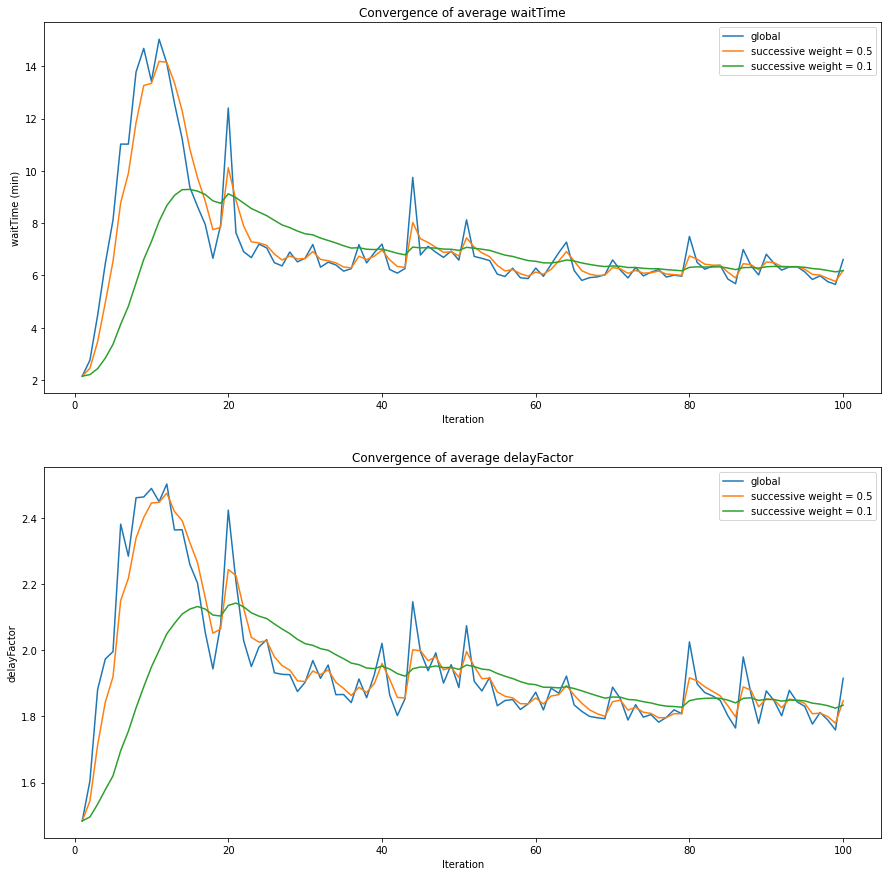

<ipython-input-32-73a2dcc3653e>:11: RuntimeWarning: invalid value encountered in double_scalars
  delayFactors.append(np.float64(it_drt_trips_stats.totalTravelTime.sum()) / it_drt_trips_stats.routerUnsharedTime.sum())
<ipython-input-32-73a2dcc3653e>:11: RuntimeWarning: invalid value encountered in double_scalars
  delayFactors.append(np.float64(it_drt_trips_stats.totalTravelTime.sum()) / it_drt_trips_stats.routerUnsharedTime.sum())


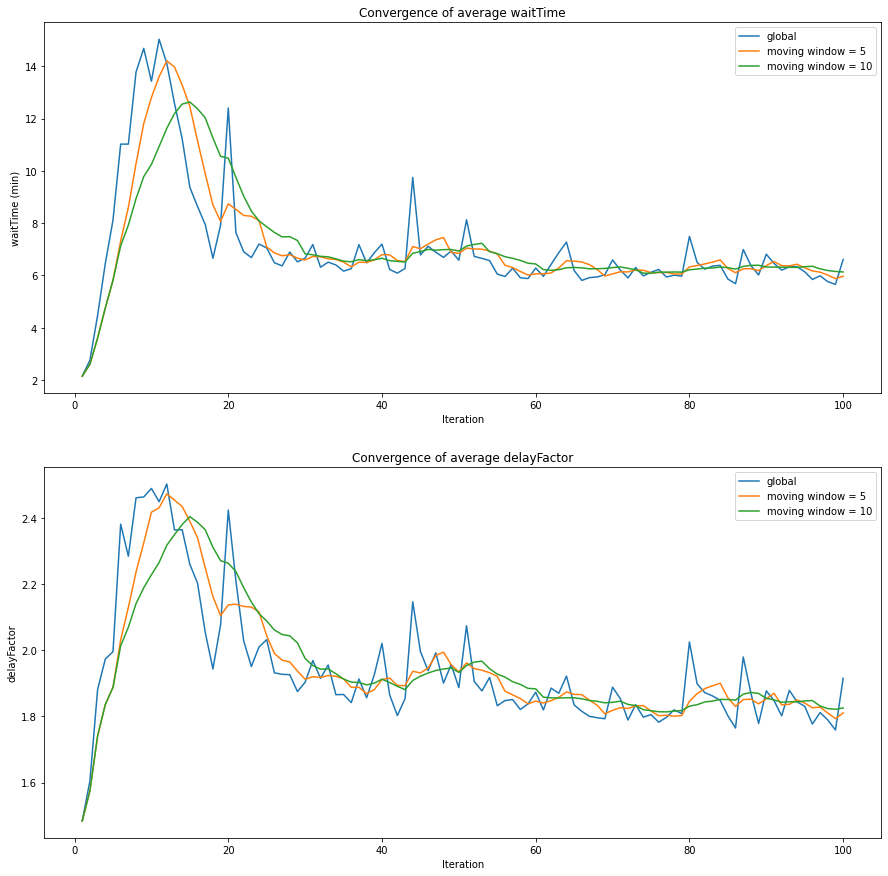

In [35]:
plot_convergence_computed(no_rej_4000, None, [0.5,0.1])
plot_convergence_computed(no_rej_4000, [5,10], None)

In [36]:
def plot_convergence_from_output(output_dict):
    waitTimes_global, delayFactors_global = collect_timeData(output_dict['global_avg'])
    waitTimes_successive, delayFactors_successive = collect_timeData(output_dict['global_successive_avg'])
    waitTimes_moving, delayFactors_moving = collect_timeData(output_dict['global_moving_avg'])
    plt.figure(figsize=(15,15))
    plt.subplot(2,1,1)
    plt.plot(waitTimes_global / 60, label='global')
    plt.plot(waitTimes_successive / 60, label='successive')
    plt.plot(waitTimes_moving / 60, label='moving')
    plt.legend()
    plt.title('Convergence of average waitTime')
    plt.ylabel('waitTime (min)')
    plt.xlabel('Iteration')
    plt.subplot(2,1,2)
    plt.plot(delayFactors_global, label='global')
    plt.plot(delayFactors_successive, label='successive')
    plt.plot(delayFactors_moving, label='moving')
    plt.legend()
    plt.title('Convergence of average delayFactor')
    plt.ylabel('delayFactor')
    plt.xlabel('Iteration')
    plt.show()

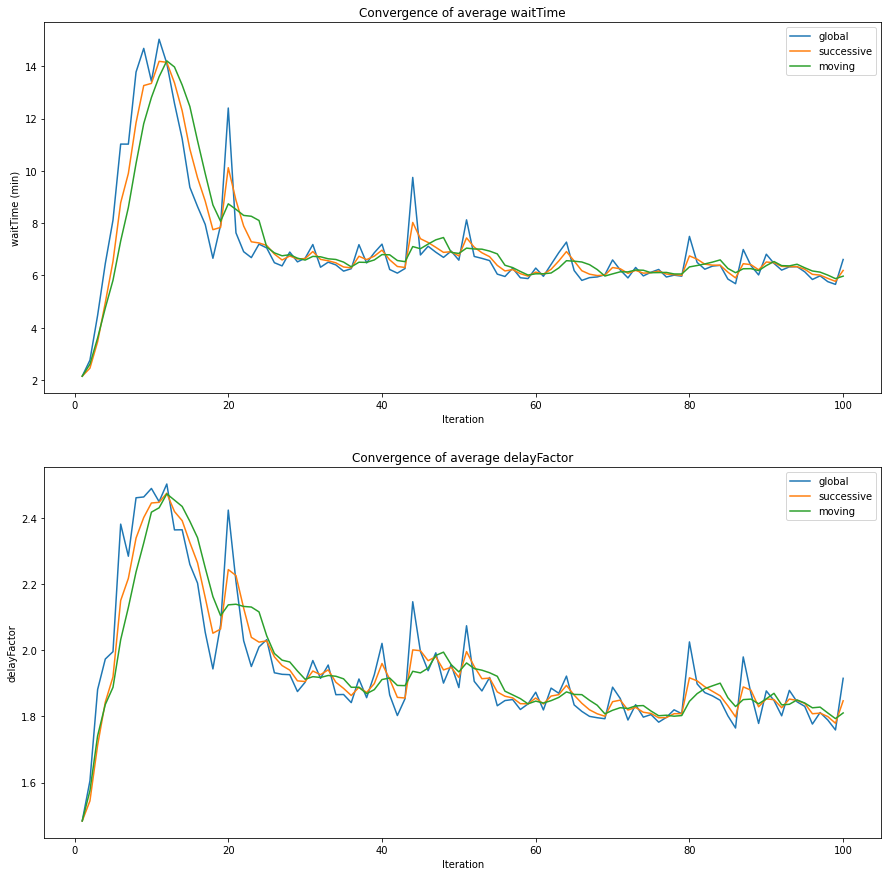

In [37]:
plot_convergence_from_output(no_rej_4000)